## **Рекуррентные нейронные сети**

1. Попробуйте обучить нейронную сеть LSTM на любом другом датасете (любимый временной ряд, текст на русском (другом языке) как генератор или классификатор, или прилагаемый набор airline-passengers - пасажиропоток для авиалиний). Опишите, какой результата вы получили? Что помогло вам улучшить ее точность?
2. *Попробуйте на numpy реализовать нейронную сеть архитектуры LSTM
3. *Предложите свои варианты решения проблемы исчезающего градиента в RNN

In [31]:
# Рисовать графики сразу же
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras

from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from sklearn.metrics import mean_absolute_error

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/airline-passengers.csv', parse_dates=['Month'], index_col=0)
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


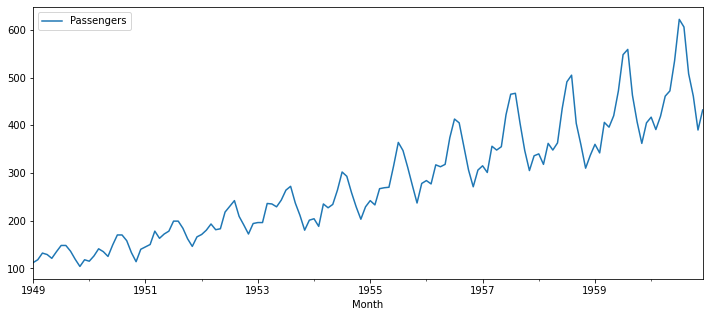

In [10]:
# view data
df.plot(figsize=(12, 5))
plt.show()

In [11]:
df['year'] = df.index.year
df['month'] = df.index.month
# df.reset_index(inplace=True)

print(df.shape)
df.head()

(144, 3)


,Passengers,year,month
Month,,,
1949-01-01,112,1949,1
1949-02-01,118,1949,2
1949-03-01,132,1949,3
1949-04-01,129,1949,4
1949-05-01,121,1949,5


In [12]:
def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

In [13]:
train_split = 120
df_v =  normalize(df.values, train_split)
df_f = pd.DataFrame(df_v)

In [14]:
# список признаков, по которым будем учить
channelIndexes = [0,1, 2]

# длина теста
valLen = 80
# длина истории для работы
xLen = 3
# отступ тестов от тренировок
bias = 10

# делим
train_data = df_f.iloc[0 : train_split - 1,channelIndexes]
val_data = df_f.iloc[train_split+bias:,channelIndexes]

In [15]:
train_data.head(7)

,0,1,2
0,-1.416335,-1.566699,-1.593255
1,-1.352874,-1.566699,-1.303572
2,-1.204797,-1.566699,-1.013890
3,-1.236528,-1.566699,-0.724207
4,-1.321143,-1.566699,-0.434524
5,-1.173066,-1.566699,-0.144841
6,-1.035567,-1.566699,0.144841


In [16]:
# шаг по данным для построения обучающих примеров
step = 1

# длина прошлого 
past = xLen
p = past
# горизонт предсказания
future = 1
h=future

# параметры модели для обучения
learning_rate = 0.001
batch_size = 32
epochs = 10

In [17]:
start = xLen + future
end = start + train_split-1

xTrain = train_data[[train_data.columns[i] for i in range(3)]].values
yTrain = df_f.iloc[start:end,0].values

sequence_length = int(xLen / step)


x_end = len(val_data) - xLen - future

label_start = len(train_data)+bias+xLen + future

xVal = val_data.iloc[:x_end+1][[val_data.columns[i] for i in range(3)]].values
yVal = df_f.iloc[label_start:,0].values

In [18]:
print(xTrain.shape)
print(yTrain.shape)
print(xVal.shape)
print(yVal.shape)

(119, 3)
(119,)
(11, 3)
(11,)


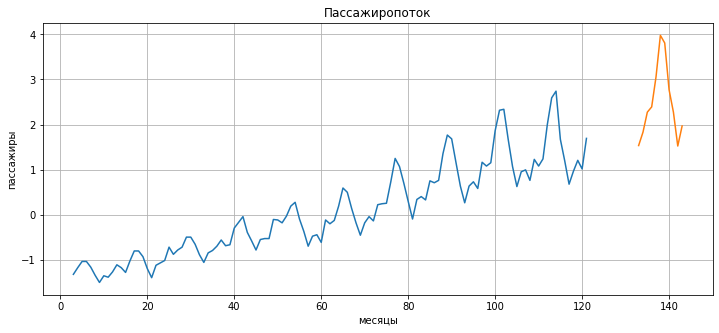

In [19]:
plt.figure(figsize=(12,5))
plt.plot(df_f.index[xLen:yTrain.shape[0]+xLen],yTrain[:])
plt.plot(df_f.index[yTrain.shape[0]+xLen+bias+future:],yVal[:])
plt.grid('on')
plt.xlabel('месяцы')
plt.ylabel('пассажиры')
plt.title('Пассажиропоток')
plt.show()

In [20]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    xTrain,
    yTrain,
    sequence_length=xLen,
    sampling_rate=1,
    batch_size=batch_size,
)
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    xVal,
    yVal,
    sequence_length=xLen,
    sampling_rate=1,
    batch_size=batch_size,
)

In [21]:
for batch in dataset_train.take(2):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (32, 3, 3)
Target shape: (32,)


In [22]:
inputs[2,:,0]

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([-1.05672038, -0.84518239, -0.79229789])>

In [23]:
targets[0]

<tf.Tensor: shape=(), dtype=float64, numpy=-0.7922978939875214>

Epoch 1/10
4/4 [==============================] - 4s 300ms/step - loss: 0.8597 - mae: 0.8015 - val_loss: 6.7566 - val_mae: 2.4814
Epoch 2/10
4/4 [==============================] - 0s 34ms/step - loss: 0.6673 - mae: 0.6990 - val_loss: 5.5284 - val_mae: 2.2267
Epoch 3/10
4/4 [==============================] - 0s 37ms/step - loss: 0.5043 - mae: 0.6020 - val_loss: 3.9804 - val_mae: 1.8573
Epoch 4/10
4/4 [==============================] - 0s 37ms/step - loss: 0.3259 - mae: 0.4779 - val_loss: 2.2056 - val_mae: 1.3138
Epoch 5/10
4/4 [==============================] - 0s 33ms/step - loss: 0.1699 - mae: 0.3320 - val_loss: 0.7837 - val_mae: 0.6275
Epoch 6/10
4/4 [==============================] - 0s 35ms/step - loss: 0.1224 - mae: 0.2536 - val_loss: 0.3922 - val_mae: 0.5111
Epoch 7/10
4/4 [==============================] - 0s 35ms/step - loss: 0.1446 - mae: 0.2954 - val_loss: 0.4320 - val_mae: 0.4856
Epoch 8/10
4/4 [==============================] - 0s 38ms/step - loss: 0.1172 - mae: 0.2674 - va

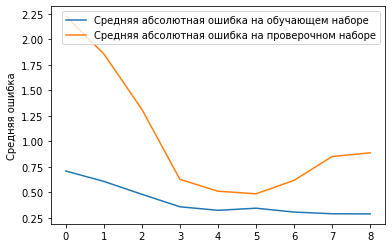

In [24]:
callback = EarlyStopping(monitor='val_mae', patience=5)

model = Sequential()

model.add(LSTM(64, input_shape = (inputs.shape[1], inputs.shape[2]), return_sequences="True"))
model.add(LSTM(64, return_sequences="True"))
model.add(Conv1D(64, 3, activation="linear"))
#model.add(Conv1D(32, 1, activation="linear"))
model.add(Flatten())
model.add(Dense(3, activation="linear"))
model.add(Dense(1, activation="linear"))

model.compile(loss="mse", optimizer="adam", metrics=['mae'])

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[callback])


plt.plot(history.history['mae'][1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [25]:
hist_val = history.history['val_mae']
hist_train = history.history['mae']

Epoch 1/10
4/4 [==============================] - 0s 44ms/step - loss: 0.1347 - mae: 0.2800 - val_loss: 1.0481 - val_mae: 0.7775
Epoch 2/10
4/4 [==============================] - 0s 34ms/step - loss: 0.1213 - mae: 0.2665 - val_loss: 0.8072 - val_mae: 0.6634
Epoch 3/10
4/4 [==============================] - 0s 35ms/step - loss: 0.1177 - mae: 0.2601 - val_loss: 0.7102 - val_mae: 0.6419
Epoch 4/10
4/4 [==============================] - 0s 39ms/step - loss: 0.1148 - mae: 0.2571 - val_loss: 0.7690 - val_mae: 0.6725
Epoch 5/10
4/4 [==============================] - 0s 38ms/step - loss: 0.1084 - mae: 0.2489 - val_loss: 0.9073 - val_mae: 0.7246
Epoch 6/10
4/4 [==============================] - 0s 33ms/step - loss: 0.1040 - mae: 0.2412 - val_loss: 0.9953 - val_mae: 0.7620
Epoch 7/10
4/4 [==============================] - 0s 35ms/step - loss: 0.1004 - mae: 0.2357 - val_loss: 0.9711 - val_mae: 0.7723
Epoch 8/10
4/4 [==============================] - 0s 34ms/step - loss: 0.0969 - mae: 0.2314 - val

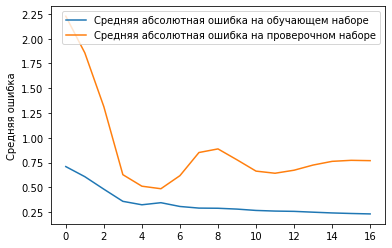

In [26]:
history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[callback])

hist_val.extend(history.history['val_mae'][:])
hist_train.extend(history.history['mae'][:])

plt.plot(hist_train[1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(hist_val[1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [27]:
pred = model.predict(dataset_train).flatten()
predVal = model.predict(dataset_val).flatten()

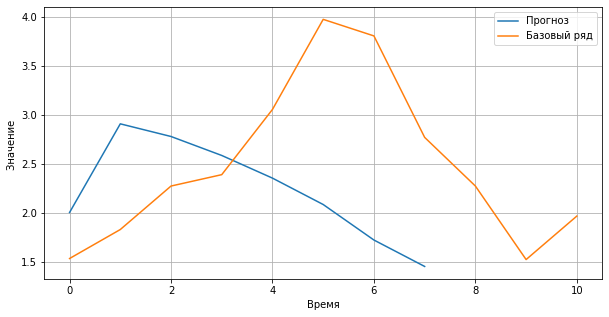

In [28]:
start = 0
step = 50
plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(predVal[h+start:h+start+step], 
         label='Прогноз')
plt.plot(yVal.flatten()[start:start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

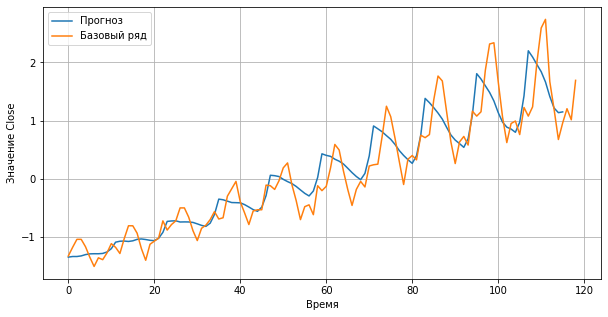

In [29]:
start = 0


plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(pred[h+start:h+train_split], 
         label='Прогноз')
plt.plot(yTrain.flatten()[start:train_split], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение Close')
plt.legend()
plt.show()

In [32]:
mean_absolute_error(yVal[:-2], predVal)

0.7690083096253578

При увеличении выборки (взяли 120), а также подбор параметров влияют на результат, в нашем случае результат улучшился. Наш прогноз почти не запаздывает, но до идеала наша модель не дотягивает. Может быть для дальнейшего улучшения качества нам необходимо больше данных. 